In [1]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
import itertools
from sklearn.metrics import silhouette_samples, silhouette_score
import os.path

# self-built module:
from CF_Helpers import cf_helpers as hlp

# Content
## 1) Create (sparse) student-course matrix
## 2) Hypertune parameter k 
## 3) Cluster Data with tuned parameters
## 4) Inspect Clusters, Predict clusters of test subjects

In [2]:
# Loading the training data to train and tune the k-Means Clustering Algorithm
train_df = pd.read_csv('C:~your_path~/RecSys/obtained_data/train_df.csv')
train_df.head()

,CourseID,StudentID,Grades
0,742001,521,5.25
1,742006,521,4.75
2,742002,521,4.50
3,742007,521,4.50
4,742067,521,4.25


In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18784 entries, 0 to 18783
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   CourseID   18784 non-null  object 
 1   StudentID  18784 non-null  int64  
 2   Grades     18784 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 440.4+ KB


## 1) Create (sparse) student-course matrix

In order to create an adequate input, one needs to map the complete course catalogue to the dataframe to make sure no items will get lost in the training and that the dimensions are of same length when predicting test subjects with the trained clusters. To ensure this, a fake dataframe with StudentID = 1 and Grade 1, for all the courses in the course catalogue is added to the training data set, and removed at a later preprocessing step. That way the dimensionality of the student-course matrix is kept and can be compressed into a sparse matrix.

In [4]:
df_complete = pd.read_csv('C:/~your_path~/RecSys/obtained_data/df_complete.csv')

In [5]:
df_complete['CourseID'].nunique()

168

In [6]:
train_df['CourseID'].nunique() 

163

**Due to splitting into training and test sets the number of dimensions might be uneven when applying the clustering algorithm!!**

In [7]:
courses = sorted(list(set(df_complete['CourseID'].unique())))

In [8]:
fake_df = pd.DataFrame({
    'StudentID': [1] * len(courses),
    'CourseID': courses,
    'Grades': [1] * len(courses)})
fake_df.head()

,StudentID,CourseID,Grades
0,1,12E050SCIENCES,1
1,1,12E051SCIENCES,1
2,1,5869,1
3,1,5870,1
4,1,71105,1


In [9]:
train_df = pd.concat([train_df, fake_df])

In [10]:
train_df = train_df.set_index('StudentID') # set StudentID as an index, to have one row per student
student_course_matrix =  train_df.pivot_table(values='Grades', index = train_df.index, columns='CourseID', aggfunc='first')
student_course_matrix = student_course_matrix.fillna(0) #fill with zero instead of np.NaN for tuning k
student_course_matrix.head()
# Result is the matrix with students as rows and courses as columns
# 163 Columns

CourseID,12E050SCIENCES,12E051SCIENCES,5869,5870,71105,71120,71121,71133,74110,74112,...,T208003,T208011,T208012,T208013,T208014,T208015,T208016,T208017,T208033,T214006
StudentID,,,,,,,,,,,,,,,,,,,,,
1,1.00,1.0,1.00,1.00,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,4.50,5.5,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.00,0.0,5.25,5.25,0.0,0.0,0.0,0.0,0.0,0.0,...,4.5,4.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.00,0.0,5.00,5.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,5.25,5.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
# As Student 1 is still in the trainings data set, the row needs to be removed, however the dimensionality of the matrix remains
student_course_matrix = student_course_matrix.drop([1])
student_course_matrix.head()

CourseID,12E050SCIENCES,12E051SCIENCES,5869,5870,71105,71120,71121,71133,74110,74112,...,T208003,T208011,T208012,T208013,T208014,T208015,T208016,T208017,T208033,T214006
StudentID,,,,,,,,,,,,,,,,,,,,,
3,4.50,5.5,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.00,0.0,5.25,5.25,0.0,0.0,0.0,0.0,0.0,0.0,...,4.5,4.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.00,0.0,5.00,5.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,5.25,5.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,5.75,5.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
# obtain the sparse format of the full matrix with csr_matrix()
sparse_matrix = csr_matrix(student_course_matrix)

In [13]:
sparse_matrix

<480x168 sparse matrix of type '<class 'numpy.float64'>'
	with 18646 stored elements in Compressed Sparse Row format>

## 2) Tuning Hyperparameter k

One approach to determine $K^*$ is the silhouette value, which can be used to validate cluster consistency. Precisely, it measures how well any observation $i$ fits its respective cluster (cohesion or *tightness* compared to other clusters (separation).The silhouette measure is composed of two measurements that are detailed in the following. <br>
For any given observation $i$, let $a(i)$ be the average dissimilarity measure of $i$ to all other observations within that very cluster, in the following denoted as $C_1$ for illustration purposes. After computing $a(i)$, a chosen dissimilarity measure $d$ is applied to determine $d(i,C_k)$ for that very observation $i$ and all other observation of other clusters, here denoted as $C_k$. By choosing the minimum of all computations, one obtains the nearest cluster or *closest neighbour* which is: <br>
<br>
\begin{equation}
    b(i) = \min_{C_k \neq C_1} d(i,C_k)
\end{equation}
<br>
Combining the average intra-cluster dissimilarity $a(i)$ and its closest neighbour as defined above as b(i), one obtains the silhouette of the $i$th observation by:<br>
\begin{equation}
    s(i) = \frac{b(i) - a(i)}{max(a(i), b(i))} \in -1 \leq s(i) \leq 1
    \label{eq:silhouette}
\end{equation}
<br>
The silhouette $s(i)$ provides insight on how well the observation $i$ is classified. A value of $s(i)$ that is close to 1, indicates that $a(i)$, the intra-cluster dissimilarity, is much smaller than the dissimilarity obtained by its closest neighbour, which implies that the observation is *well-clustered*. A negative value close to -1 implies the exact opposite, the nearest neighbour cluster is much closer than the actual cluster, such that one can infer that $i$ is misclassified. For values around zero, the data might not be clearly separable as $a(i)$ and $b(i)$ are approximately the same, such that $i$ could belong to either cluster. Using the silhouette value of clustered observations can assist in further fine-tuning the hyperparameter $k$ as it provides the opportunity to validate the cohesion of the clusters obtained

In [14]:
k_values = range(2, 12 + 1, 1) 
sil_scores = [hlp.silhouette_score_by_cluster(k, sparse_matrix) for k in k_values]

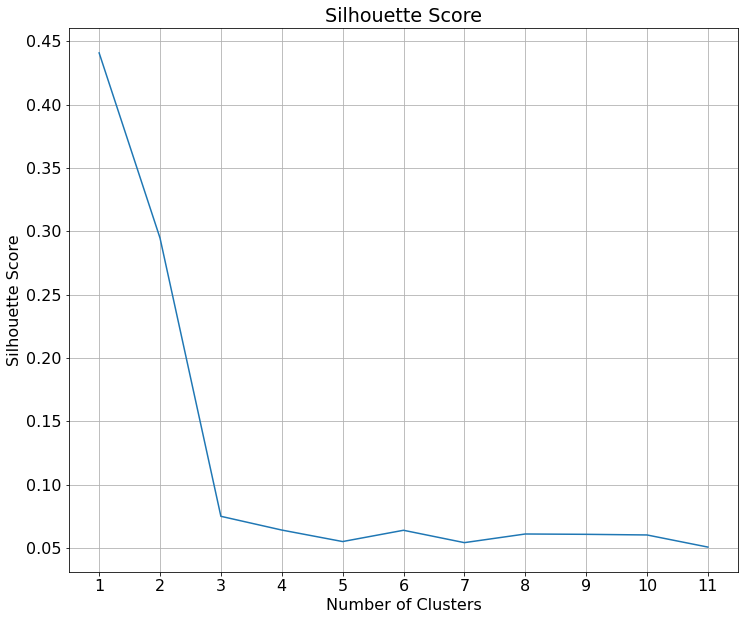

In [15]:
plt.rcParams.update({'font.size': 16})
x = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11']
fig, ax = plt.subplots(figsize=(12, 10))
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Silhouette Score')
plt.plot(x, sil_scores)
plt.title("Silhouette Score")
plt.grid()
plt.show()

The highest silhouette score is obtained with dividing the data into 2 clusters. Values near 0, indicate that clusters are not distinct and somehow overlap. This is naturally the case in the underlying data set, as the course history is a mix of mandatory and elective courses. Thus, the silhouette score is expected to obtain lower values as each student will have to some extend the same courses.

In [16]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 100,
     "max_iter": 300,
    "random_state": 32,
}

In [17]:
# A list holds the SSE values for each k (Within Cluster Variation, also often denoted as W(C_k))
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters= k, **kmeans_kwargs)
    kmeans.fit(sparse_matrix)
    sse.append(kmeans.inertia_)

In [18]:
number_of_clusters = list(range(0,10))
number_of_clusters

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [19]:
sse_frame = pd.DataFrame({
    'SSE': sse,
}, index = number_of_clusters)

In [20]:
sse_frame['Pct_change'] = sse_frame.pct_change()

In [21]:
sse_frame = sse_frame.round(4)
sse_frame

,SSE,Pct_change
0,312098.3509,NaN
1,154459.0945,-0.5051
2,149892.9871,-0.0296
3,146378.7574,-0.0234
4,143531.1635,-0.0195
5,141117.1862,-0.0168
6,139851.9413,-0.0090
7,138300.6753,-0.0111
8,136948.7441,-0.0098
9,136085.2432,-0.0063


### What about scaling features?
**In this very case**, working with grades that follow a predefined scale, the practice of scaling features does not significantly add to determining the number of clusters.

**Reasoning behind the heuristic approach of examining the Within Cluster Variation:** <br>
A data-based method for estimating the optimal number of clusters, in the following denoted as $K^*$, depicts the number of clusters as a function of the Within-Cluster variation measure $W(C_k)$. With increasing number of clusters $k$, the corresponding value of $W(C_k)$ decreases, such that if $K^* = N$, with $N$ being the total number of observations, the value of $W(C_k)$ equals zero. This phenomena can be equally observed, when validating the measure of $W(C_k)$ on an independent test set, such that cross-validation methods for obtaining $K^*$ is not applicable in this setting. We are dealing here with an unsupervised learning algorithm.<br>However, such a data-based approach is still of use due to the following reasoning. If $K^*$ non-overlapping clusters in the data set exist, then for any $K$ < $K^*$ the obtained partitioning will contain at least a subset of the true, natural clusters. The measurement of the objective function $W(C_k)$ will hence decrease substantially, with each additional cluster added below $K^*$, as the algorithm will not assign observations that are part of an existing group to different clusters. However, as soon as $K$ > $K^*$, the algorithm will divide an existing group into two subgroups, such that the defined solution criteria will reduce significantly less. It follows that there must be sharp successive decreasing values in the measurement of interest until $K$ = $K^*$. Although this is rather a heuristic approach, this process aids in the selection of the optimal number of clusters, when visually depicted.

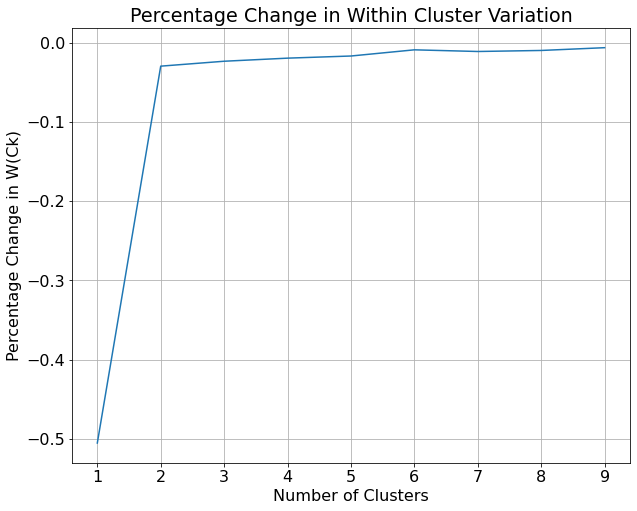

In [22]:
x = ['0','1', '2', '3', '4', '5', '6', '7', '8', '9']
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Percentage Change in W(Ck)')
plt.plot(x, sse_frame['Pct_change'])
plt.title('Percentage Change in Within Cluster Variation')
plt.grid()
plt.show()

**Result**:<br>
The percentage change from 2 to 3 clusters is insignificant in comparison to the decrease in $W(C_k)$ from 1 to 2 clusters. This is in accordance to the silhouette method and thus the optimal number of $K*$ is set to **2**.

## 3) Cluster Data with tuned k

In [23]:
kmeans_algo = KMeans(n_clusters = 2, algorithm='full', random_state = 42, max_iter = 100)

In [24]:
kmeans_algo.fit(sparse_matrix)

KMeans(algorithm='full', max_iter=100, n_clusters=2, random_state=42)

In [25]:
kmeans_algo.inertia_ # lowest value for obtained sum of squared errors 

154459.09446137445

In [26]:
kmeans_algo.labels_[:10] # cluster labels of first ten students in the training set

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [27]:
# Cordinates of the cluster centeres
kmeans_algo.cluster_centers_[0][:15] # some cluster centers are very close (clusters might overlap), some have a decent distance

array([1.74156118, 1.71518987, 1.16561181, 1.14451477, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [28]:
kmeans_algo.cluster_centers_[1][:15]

array([0.        , 0.        , 0.        , 0.        , 0.15534979,
       0.45781893, 0.31790123, 0.40946502, 2.22427984, 0.29320988,
       2.46502058, 2.98662551, 5.0308642 , 2.62037037, 2.64197531])

In [29]:
len(kmeans_algo.cluster_centers_[0]) 
# 163 courses (number of features), each feature has a coordinate to assigned to their cluster center

168

In [30]:
kmeans_algo.n_iter_ #only 2 iterations until convergence

2

In [31]:
train_predictions = kmeans_algo.predict(sparse_matrix)

## 4) Inspect Clusters, Predict clusters of test subjects

In [32]:
#inspecting clusters 
predicted_cluster_train = pd.concat([student_course_matrix.reset_index(), pd.DataFrame({'cluster':train_predictions})], axis=1)
predicted_cluster_train.head()

,StudentID,12E050SCIENCES,12E051SCIENCES,5869,5870,71105,71120,71121,71133,74110,...,T208011,T208012,T208013,T208014,T208015,T208016,T208017,T208033,T214006,cluster
0,3,4.50,5.5,0.00,0.00,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,4,0.00,0.0,5.25,5.25,0.0,0.0,0.0,0.0,0.0,...,4.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,5,0.00,0.0,5.00,5.00,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,7,5.25,5.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,8,5.75,5.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [33]:
train_predictions[:20]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [34]:
len(train_predictions)

480

In [35]:
cluster_1 = predicted_cluster_train[predicted_cluster_train.cluster == 0]
cluster_2 = predicted_cluster_train[predicted_cluster_train.cluster == 1]

In [36]:
cluster_1 # (cluster numbers start at 0)

,StudentID,12E050SCIENCES,12E051SCIENCES,5869,5870,71105,71120,71121,71133,74110,...,T208011,T208012,T208013,T208014,T208015,T208016,T208017,T208033,T214006,cluster
0,3,4.50,5.5,0.00,0.00,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0
1,4,0.00,0.0,5.25,5.25,0.0,0.0,0.0,0.0,0.0,...,4.25,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0
2,5,0.00,0.0,5.00,5.00,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0
3,7,5.25,5.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0
4,8,5.75,5.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232,293,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0
233,295,0.00,0.0,5.00,5.50,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.0,5.25,0.0,0.0,0.0,0.0,0.0,0
234,297,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,...,0.00,4.75,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0
235,298,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,...,0.00,5.75,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0


In [37]:
cluster_2

,StudentID,12E050SCIENCES,12E051SCIENCES,5869,5870,71105,71120,71121,71133,74110,...,T208011,T208012,T208013,T208014,T208015,T208016,T208017,T208033,T214006,cluster
237,301,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
238,302,0.0,0.0,0.0,0.0,0.0,5.5,0.0,0.0,5.75,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
239,303,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
240,304,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.25,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
241,305,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.50,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,595,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
476,596,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.50,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
477,597,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.50,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
478,598,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [38]:
students_per_cluster = [len(cluster_1), len(cluster_2)]
students_per_cluster

[237, 243]

In [39]:
cluster_number = ['1', '2']

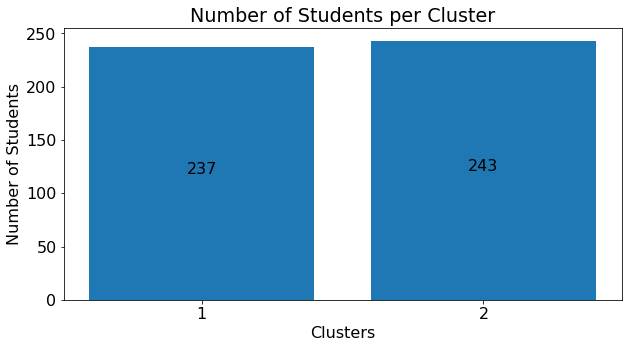

In [40]:
# creating data on which bar chart will be plot
x = cluster_number
y = students_per_cluster
      
    # setting figure size by using figure() function 
plt.figure(figsize = (10, 5))
      
    # making the bar chart on the data
plt.bar(x, y)
      
    # calling the function to add value labels
hlp.addlabels(x, y)
      
    # giving title to the plot
plt.title("Number of Students per Cluster")
      
    # giving X and Y labels
plt.xlabel("Clusters")
plt.ylabel("Number of Students")   
    # visualizing the plot
plt.show()



In [41]:
predicted_cluster_train.to_csv(os.path.join('C:~your_path~/RecSys/obtained_data', 'predicted_cluster_train.csv'), index = False) 

In [42]:
# predicting test subjects to existing clusters:
# step 1) load test data
# step 2) create student course matrix with test data
# step 3) predict respective cluster of test subjects with obtained k means fit


test_df = pd.read_csv('C:~your_path~/RecSys/obtained_data/test_df_NaN.csv')

In [45]:
test_df = pd.concat([test_df, fake_df])

In [46]:
test_df = test_df.set_index('StudentID')
test_matrix = test_df.pivot_table(values = 'Grades', index = test_df.index, columns = 'CourseID', aggfunc = 'first')
test_matrix = test_matrix.fillna(0)


In [47]:
test_matrix.head()

CourseID,12E050SCIENCES,12E051SCIENCES,5869,5870,71105,71120,71121,71133,74110,74112,...,T208003,T208011,T208012,T208013,T208014,T208015,T208016,T208017,T208033,T214006
StudentID,,,,,,,,,,,,,,,,,,,,,
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
# remove fake student to match dimensionality of the input matrix
test_matrix = test_matrix.drop([1])
test_matrix.head()

CourseID,12E050SCIENCES,12E051SCIENCES,5869,5870,71105,71120,71121,71133,74110,74112,...,T208003,T208011,T208012,T208013,T208014,T208015,T208016,T208017,T208033,T214006
StudentID,,,,,,,,,,,,,,,,,,,,,
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
# create sparse matrix
test_sparse = csr_matrix(test_matrix) 

In [50]:
# predict sujects to exsiting clusters
test_predictions = kmeans_algo.predict(test_sparse)


In [51]:
predicted_cluster_test = pd.concat([test_matrix.reset_index(), pd.DataFrame({'cluster': test_predictions})], axis = 1)
predicted_cluster_test.head()

,StudentID,12E050SCIENCES,12E051SCIENCES,5869,5870,71105,71120,71121,71133,74110,...,T208011,T208012,T208013,T208014,T208015,T208016,T208017,T208033,T214006,cluster
0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [52]:
predicted_cluster_test.tail()

,StudentID,12E050SCIENCES,12E051SCIENCES,5869,5870,71105,71120,71121,71133,74110,...,T208011,T208012,T208013,T208014,T208015,T208016,T208017,T208033,T214006,cluster
114,581,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
115,584,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
116,585,0.0,0.0,0.0,0.0,0.0,0.0,4.25,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
117,590,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
118,599,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,5.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [53]:
test_predictions

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1])

In [54]:
cluster, counts = np.unique(test_predictions, return_counts = True)
dict(zip(cluster, counts))

{0: 62, 1: 57}

In [55]:
# saving the state as csv to obtained_data folder

predicted_cluster_test.to_csv(os.path.join('C:/~your_path~/RecSys/obtained_data', 'predicted_cluster_test.csv'), index = False)
